# Plot Intro Case

Interesting cases: al122024 (Kirk), sh022025 (Bheki), sh132025

Wind profile evolution with all the marks (Rmax/Vmax, f, Rxx, B, Uc, Rossby,  R+/R0) and insets with the evolution of each of these parameters on the side. For now color in shades of black to brown for before LMI, and shades of red-to-purple for after.

Eventually add Argo profiles, MSLP, etc ?

TODO: Add best-track values (ask Alexis first, Kirk is the plot from the RSE Sentinel-1 review and Rmax_BTK is quite accurate).

In [1]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/03_PLOT_INTRO_CASE/'
}

### Open data
dsg  = xr.open_dataset(PTHS['sar_pth'])

In [3]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [4]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


In [63]:
# ### Colormap
# # Pour le segment négatif (-72 à 0)
# color_start_neg = 'black'           # Couleur à -72
# color_end_neg   = 'darkgoldenrod' # Couleur à 0 (côté négatif)

# # Pour le segment positif (0 à 72)
# color_start_pos = 'burlywood'          # Couleur à 0 (côté positif)
# color_end_pos   = 'crimson'        # Violet (couleur choisie pour l'exemple : 'blueviolet')

# # --- 2. Créer les deux segments de colormap ---
# # Segment pour les valeurs négatives : de noir à marron clair
# # N=128 pour avoir suffisamment de points d'échantillonnage pour un dégradé lisse
# cmap_neg_segment = mcolors.LinearSegmentedColormap.from_list(
#     'neg_part_cmap', [color_start_neg, color_end_neg], N=128
# )

# # Segment pour les valeurs positives : de rouge à violet
# cmap_pos_segment = mcolors.LinearSegmentedColormap.from_list(
#     'pos_part_cmap', [color_start_pos, color_end_pos], N=128
# )

# # --- 3. Combiner les deux segments en une seule colormap ---
# # Nous échantillonnons chaque segment et les empilons.
# # Le nombre total de couleurs N=256 est standard pour une bonne résolution.
# combined_colors = np.vstack((
#     cmap_neg_segment(np.linspace(0, 1, 128)), # Échantillonne le segment négatif
#     cmap_pos_segment(np.linspace(0, 1, 128))  # Échantillonne le segment positif
# ))

# # Crée la colormap finale à partir des couleurs combinées
# cmap = mcolors.LinearSegmentedColormap.from_list(
#     'black_brown_red_violet_continuous', combined_colors, N=256
# )

# norm = mcolors.TwoSlopeNorm(vmin=-72, vcenter=0, vmax=72)
# cmap

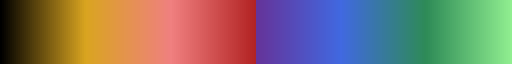

In [61]:
### Colormap

# Définition des limites de la plage totale
vmin = -72
vmax = 72

# Segment 1: -72 à -48
color_neg_72 = 'black'
color_neg_48 = 'goldenrod' 

# Segment 2: -48 à -24
color_neg_24 = 'lightcoral' 

# Segment 3: -24 à 0
color_zero_neg_side = 'firebrick' 

# Segment 4: 0 à 24
color_zero_pos_side = 'rebeccapurple' 

# Segment 5: 24 à 48
color_pos_24 = 'royalblue'

# Segment 6: 48 à 72
color_pos_48 = 'seagreen'
color_pos_72 = 'lightgreen' 

# Fonction utilitaire pour normaliser une valeur
def normalize_value(val, vmin, vmax):
    return (val - vmin) / (vmax - vmin)

colors_and_positions = [
    # Segment 1: -72 à -48 (de noir à rouge foncé)
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),

    # Segment 2: -48 à -24 (de rouge foncé à orange)
    # Note: color_neg_48 est répété pour assurer la continuité
    (normalize_value(-48, vmin, vmax), color_neg_48), # Point de départ du segment 2
    (normalize_value(-24, vmin, vmax), color_neg_24),

    # Segment 3: -24 à 0 (d'orange à gris clair)
    (normalize_value(-24, vmin, vmax), color_neg_24), # Point de départ du segment 3
    (normalize_value(0, vmin, vmax), color_zero_neg_side),

    # Segment 4: 0 à 24 (de gris clair à bleu clair)
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Point de départ du segment 4
    (normalize_value(24, vmin, vmax), color_pos_24),

    # Segment 5: 24 à 48 (de bleu clair à vert foncé)
    (normalize_value(24, vmin, vmax), color_pos_24), # Point de départ du segment 5
    (normalize_value(48, vmin, vmax), color_pos_48),

    # Segment 6: 48 à 72 (de vert foncé à violet à jaune vif)
    (normalize_value(48, vmin, vmax), color_pos_48), # Point de départ du segment 6
    (normalize_value(vmax, vmin, vmax), color_pos_72),
]

cmap_points = [
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),
    (normalize_value(-24, vmin, vmax), color_neg_24),
    (normalize_value(0, vmin, vmax), color_zero_neg_side), # Couleur à 0 pour les négatifs
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Couleur à 0 pour les positifs (pour une transition nette si désirée)
    (normalize_value(24, vmin, vmax), color_pos_24),
    (normalize_value(48, vmin, vmax), color_pos_48),
    (normalize_value(vmax, vmin, vmax), color_pos_72)
]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_multi_segment_cmap", cmap_points)

# Pour la normalisation, TwoSlopeNorm est toujours appropriée si 0 est votre centre de pivot
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

cmap

In [6]:
# Select case
ds = d.where(d.id == 'al122024', drop=True)

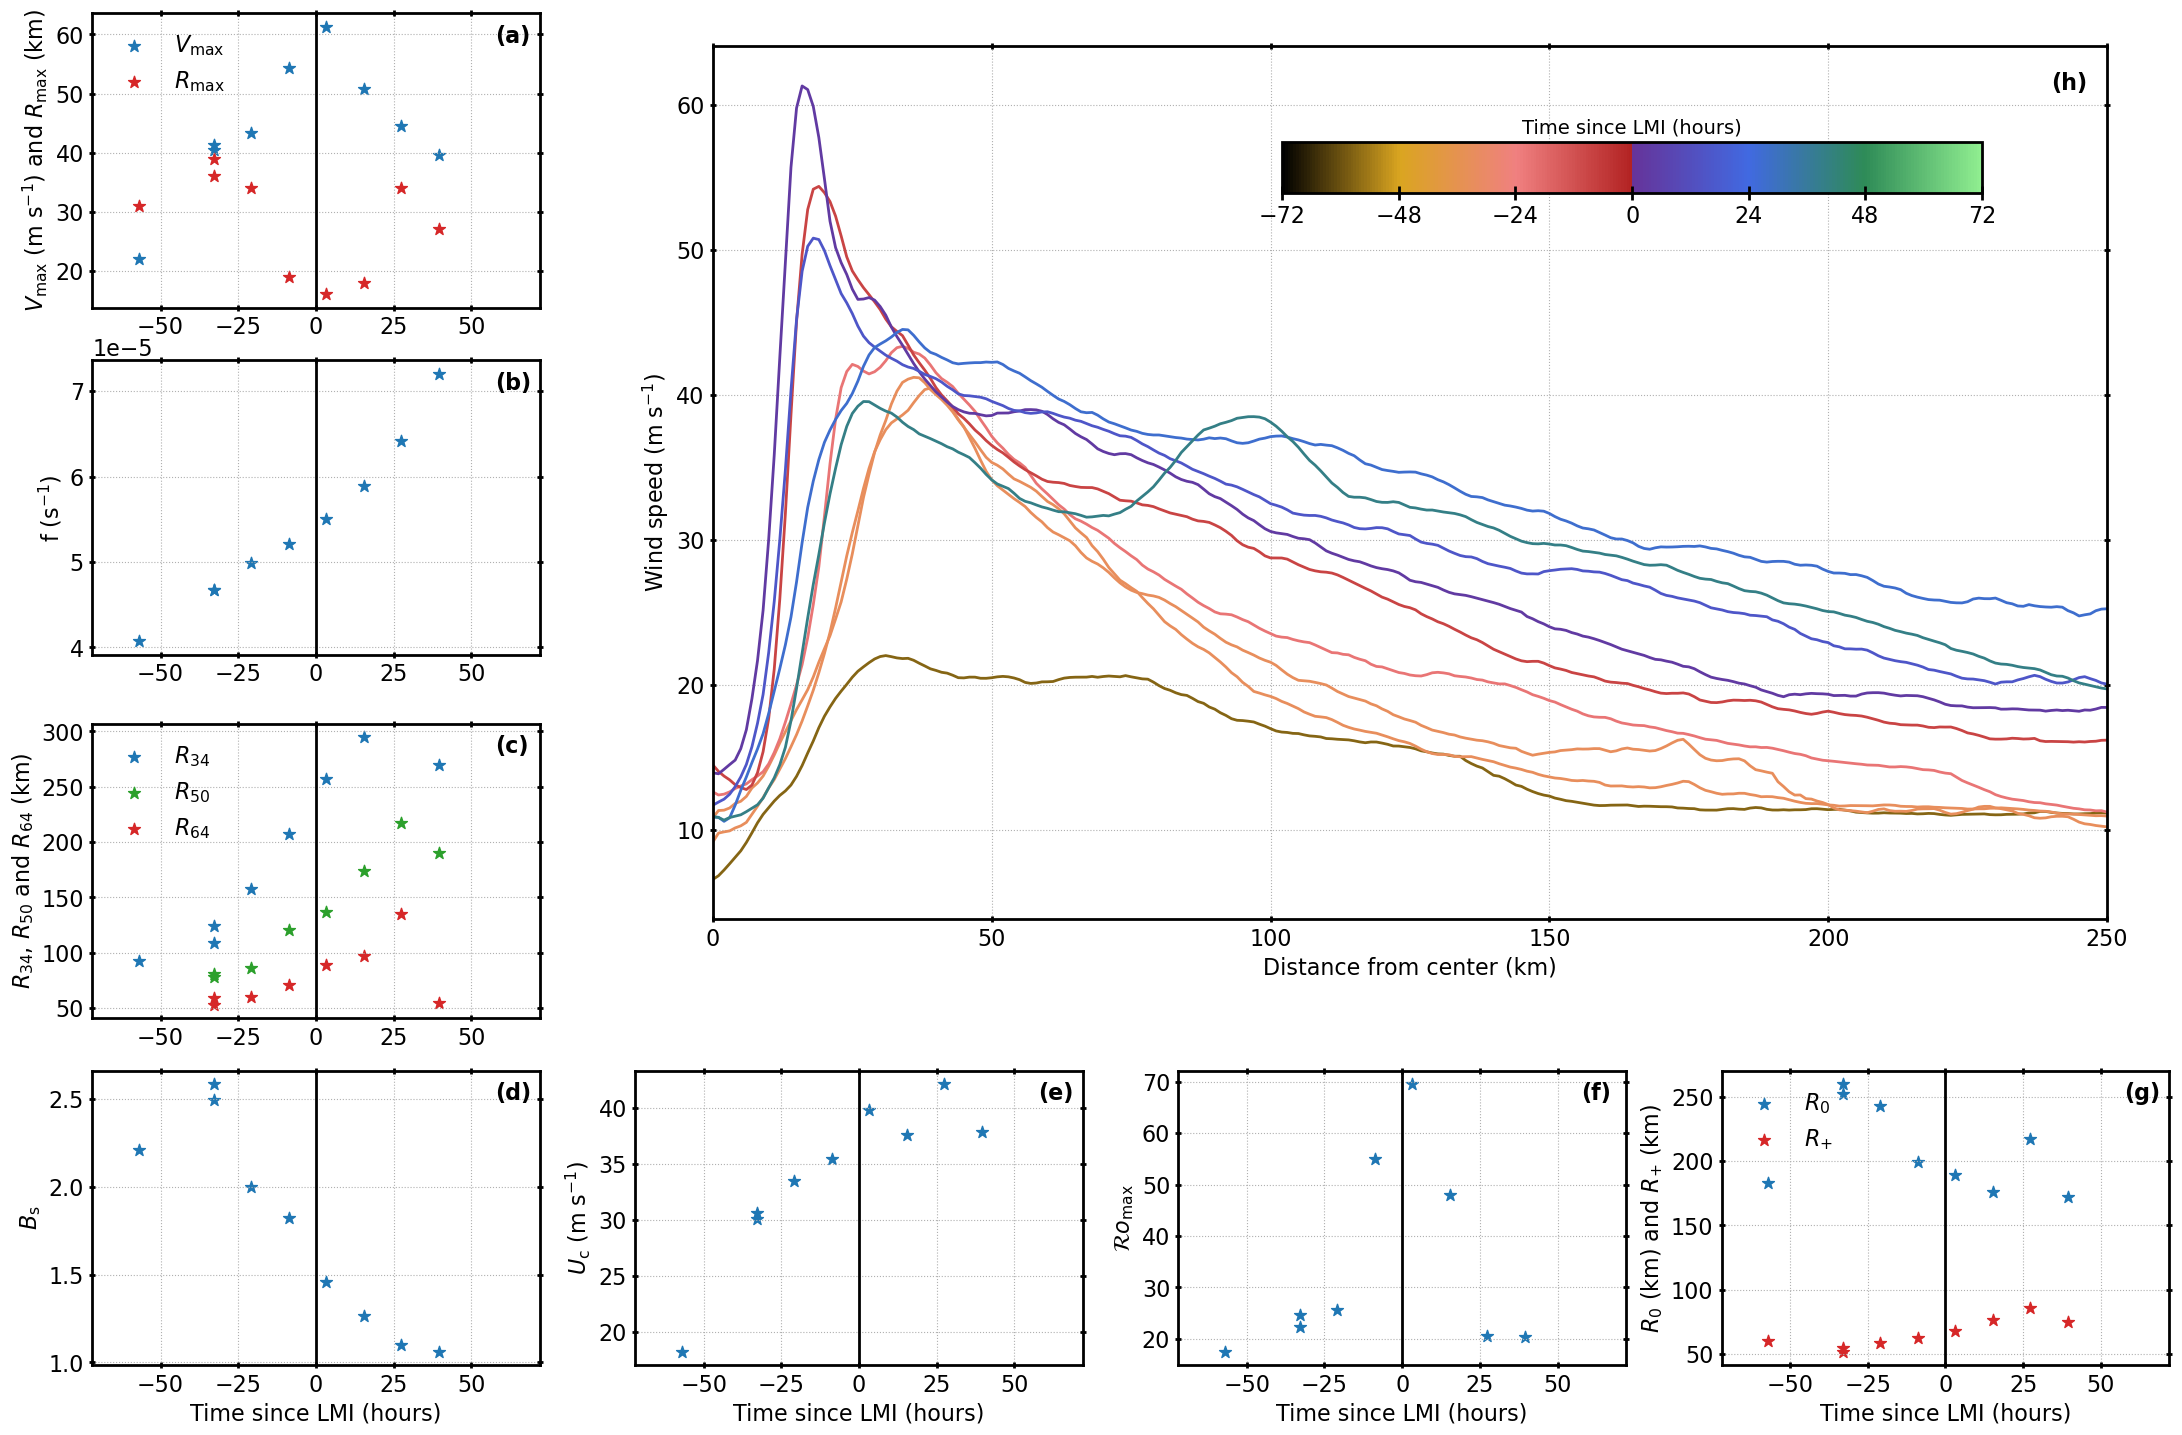

In [157]:
### Hyperparameters
ticks  = np.arange(-72, 73, 24)
ax_lim = 250


fig = plt.figure(figsize = (28, 30))

# Define the number of division, 1st vertical 2nd horizontal
# It's convenient to put a large number of division to perform smart tuning of the subplot position
gs  = GridSpec(140, 140) 

################
### PROFILES ###
################
ax = fig.add_subplot(gs[2:55, 40:130])
ax.text(0.96, 0.95, '(h)', transform=ax.transAxes, weight='bold')

for t in range(len(ds.time)):
    # Open
    dss = ds.isel(time=t)
    dsp = xr.open_dataset(PTHS['sar_dir'] + dss.file_tcva.item()).isel(time=0)
    wsm = dsp.wind_speed.mean(dim='theta')

    # Plot
    ax.plot(wsm.rad / 1000, wsm, c=cmap(norm(dss.t_since_lmi_ibt / 3600)), linewidth=2)

    # Close
    dsp.close()

# Axes
ax.set_xlim(0, ax_lim)
ax.set_ylabel(r'Wind speed (m s$^{-1}$)')
ax.set_xlabel(r'Distance from center (km)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# Colorbar
sm   = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.55, 0.82, 0.25, 0.017]) # Position of the colorbar (this is tricky just do tests)
cbar    = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', ticks=ticks)
cbar_ax.set_title(r'Time since LMI (hours)', fontsize=fontsize-2, x=0.5, y=1.02)
cbar.ax.yaxis.set_offset_position('right')
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout', width=2, length=10, labelsize=16)

################
### RMX/VMX  ###
################
ax = fig.add_subplot(gs[:18, :29])
ax.text(0.9, 0.9, '(a)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx,        marker='*', s=80, color='tab:blue', label=r'$V_{\text{max}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rmx / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{max}}$')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$V_{\text{max}}$ (m s$^{-1}$) and $R_{\text{max}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   FCOR   ###
################
ax = fig.add_subplot(gs[21:39, :29])
ax.text(0.9, 0.9, '(b)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.fcor,        marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'f (s$^{-1})$')
# ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###   Rxx    ###
################
ax = fig.add_subplot(gs[43:61, :29])
ax.text(0.9, 0.9, '(c)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r34 / 1000, marker='*', s=80, color='tab:blue',  label=r'$R_{\text{34}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r50 / 1000, marker='*', s=80, color='tab:green', label=r'$R_{\text{50}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r64 / 1000, marker='*', s=80, color='tab:red',   label=r'$R_{\text{64}}$')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{34}}$, $R_{\text{50}}$ and $R_{\text{64}}$ (km)')
# ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Bs    ###
################
ax = fig.add_subplot(gs[64:82, :29])
ax.text(0.9, 0.9, '(d)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.B_hol, marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$B_{\text{s}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###    Uc    ###
################
ax = fig.add_subplot(gs[64:82, 35:64])
ax.text(0.9, 0.9, '(e)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.uc, marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$U_{\text{c}}$ (m s$^{-1}$)')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  Rossby  ###
################
ax = fig.add_subplot(gs[64:82, 70:99])
ax.text(0.9, 0.9, '(f)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rsby, marker='*', s=80, color='tab:blue')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$\mathcal{R}o_{\text{max}}$')
ax.set_xlabel(r'Time since LMI (hours)')

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

################
###  R+/R0   ###
################
ax = fig.add_subplot(gs[64:82, 105:134])
ax.text(0.9, 0.9, '(g)', transform=ax.transAxes, weight='bold')

# Plot
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.r0 / 1000,  marker='*', s=80, color='tab:blue', label=r'$R_{\text{0}}$')
ax.scatter(ds.t_since_lmi_ibt / 3600, ds.rps / 1000, marker='*', s=80, color='tab:red',  label=r'$R_{\text{+}}$')

# LMI
plt.axvline(0, c='k', linewidth=2)

# Axes
ax.set_xlim(-72, 72)
ax.set_ylabel(r'$R_{\text{0}}$ (km) and $R_{\text{+}}$ (km)')
ax.set_xlabel(r'Time since LMI (hours)')
ax.legend(frameon=False)

# Remove every ticks and make a bold frame
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(direction='inout', width=0, length=0, bottom='off', top='off', left='off', right='off')
ax.tick_params(direction='inout', width=2, length=5, bottom=1, top=1, left=1, right=1) #set the tick parameters
ax.grid(ls=':')

# # Save
# plt.savefig(PTHS['sav_dir'] + 'intro_case.png', bbox_inches='tight')

### Perhaps choose other cases

In [17]:
ids, cts = np.unique(d.id, return_counts=True)

In [64]:
# for atcf_id in ids[cts >= 8]:
#     print(atcf_id)
#     ds = d.where(d.id == atcf_id, drop=True)
#     plt.scatter(ds.t_since_lmi_ibt / 3600, ds.vmx)
#     plt.axvline(0, c='k')
#     plt.grid()
#     plt.xlim(-72, 72)
#     plt.show()